### spatial variation of ellipsoidal height using pixc data.
1. centeralization of height_ellipsoid (i.e., spatial variation of height_ellipsoid);   
2. covert multitemporal pixc-based spatial variation of height to raster data
3. temporal smoothing for spatial variation of height_ellipsoid.


In [1]:
import numpy as np
import xarray as xr
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.functions import meter2deg
from utils.pixc2raster import pixc2raster


In [2]:
path_lake_vec = 'data/siling_co-lake/hydrolake_siling_co.gpkg'
dir_pixc = 'data/siling_co-lake/swot-pixc'
paths_pixc_filtered = sorted(glob(dir_pixc + '/*masked_filtered.nc'))  # Get the first .nc file in the directory
print(len(paths_pixc_filtered))
paths_pixc_filtered[0]


11


'data/siling_co-lake/swot-pixc/SWOT_L2_HR_PIXC_009_217_210L_20240111T212154_20240111T212205_PIC0_01_masked_filtered.nc'

In [3]:
## 1. read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)


### 1. calculate the spatial heterogeneity of height for pixc data

In [4]:
## calculate the corrected geoid 
pixcs_spavar_ls = []
for path in paths_pixc_filtered:
    pixc_filtered_xr = xr.open_dataset(path)
    pixc_spavar_xr = pixc_filtered_xr[['geoid', 'ht_valid_ids']]
    ## calculate corrected geoid
    pixc_ht_ellip = pixc_filtered_xr['ht_ortho_filter2'].values + pixc_filtered_xr['geoid'].values
    pixc_ht_ellip_spavar = pixc_ht_ellip - np.nanmean(pixc_ht_ellip)    ## i.e., spatial variance of height anomalies
    geoid_mean = np.nanmean(pixc_filtered_xr['geoid'])
    pixc_geoid_cor = geoid_mean + pixc_ht_ellip_spavar    ## Pixc Geoid correction
    ## save as DataArray
    pixc_spavar_xr = pixc_spavar_xr.assign({'geoid_cor': (("points",), pixc_geoid_cor)})
    pixc_spavar_xr = pixc_spavar_xr.assign({'ht_ellip_spavar': (("points",), pixc_ht_ellip_spavar)})
    pixc_spavar_xr['geoid_cor'].attrs['description'] = 'corrected geoid of PIXC points'
    pixc_spavar_xr['ht_ellip_spavar'].attrs['description'] = 'spatial variation of lake surface height'
    pixcs_spavar_ls.append(pixc_spavar_xr)
pixc_spavar_xr


<xarray.Dataset> Size: 143MB
Dimensions:          (points: 4939080)
Coordinates:
    latitude         (points) float64 40MB ...
    longitude        (points) float64 40MB ...
Dimensions without coordinates: points
Data variables:
    geoid            (points) float32 20MB -34.42 -34.42 ... -35.08 -35.08
    ht_valid_ids     (points) bool 5MB ...
    geoid_cor        (points) float32 20MB -34.45 nan nan nan ... nan nan nan
    ht_ellip_spavar  (points) float32 20MB 0.3184 nan nan nan ... nan nan nan
Attributes:
    date:     2024-12-31

In [5]:
pixcs_spavar_xr = xr.concat(pixcs_spavar_ls, dim='points')   ## merge multitemporal xarray dataset.
pixcs_spavar_xr = pixcs_spavar_xr[['ht_ellip_spavar']]
pixcs_spavar_xr


<xarray.Dataset> Size: 1GB
Dimensions:          (points: 54387914)
Coordinates:
    latitude         (points) float64 435MB 31.71 31.71 31.71 ... 32.01 32.01
    longitude        (points) float64 435MB 88.74 88.74 88.74 ... 88.97 88.97
Dimensions without coordinates: points
Data variables:
    ht_ellip_spavar  (points) float32 218MB nan nan nan nan ... nan nan nan nan
Attributes:
    date:     2024-01-11

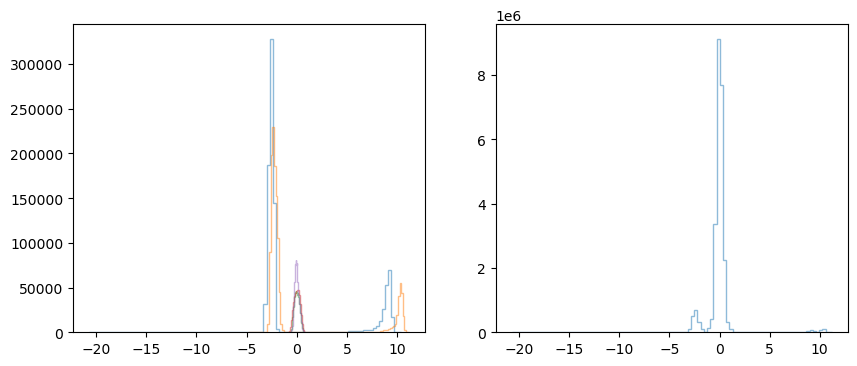

In [6]:
fig, ax = plt.subplots(1,2,figsize=(10, 4))
ax[0].hist(pixcs_spavar_ls[0]['ht_ellip_spavar'].values, bins=100, alpha=0.5, histtype='step');
ax[0].hist(pixcs_spavar_ls[1]['ht_ellip_spavar'].values, bins=100, alpha=0.5, histtype='step');
ax[0].hist(pixcs_spavar_ls[2]['ht_ellip_spavar'].values, bins=100, alpha=0.5, histtype='step');
ax[0].hist(pixcs_spavar_ls[3]['ht_ellip_spavar'].values, bins=100, alpha=0.5, histtype='step');
ax[0].hist(pixcs_spavar_ls[4]['ht_ellip_spavar'].values, bins=100, alpha=0.5, histtype='step');
ax[1].hist(pixcs_spavar_xr['ht_ellip_spavar'].values, bins=100, alpha=0.5, histtype='step');


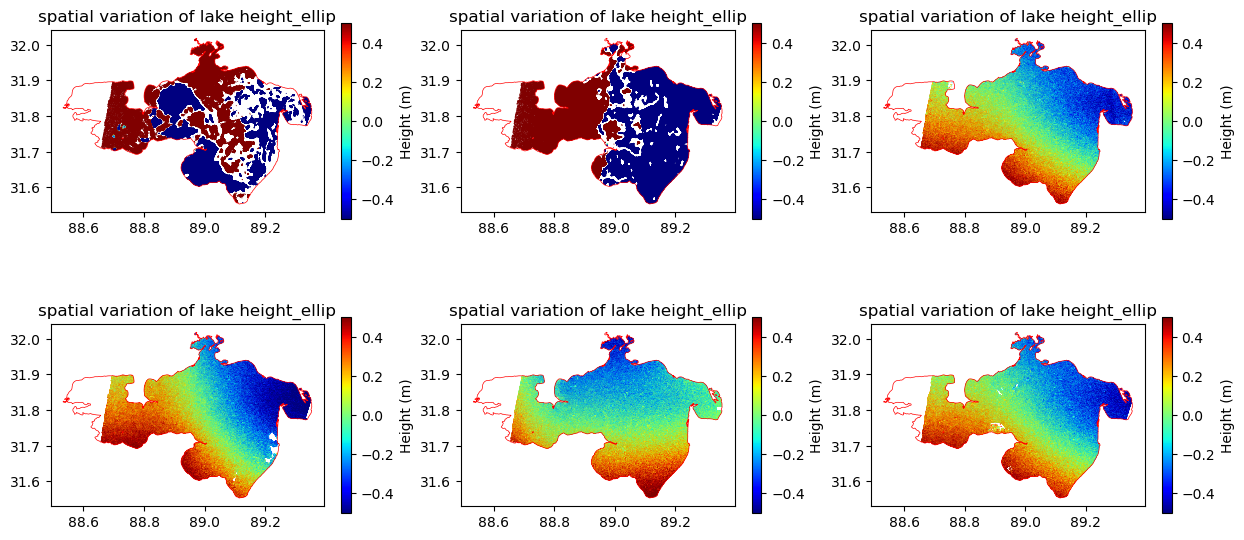

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
for i in range(2):
  for j in range(3):
    idx = i*3 + j
    if idx >= len(pixcs_spavar_ls): break
    scat = ax[i][j].scatter(x=pixcs_spavar_ls[idx].longitude, 
                            y=pixcs_spavar_ls[idx].latitude, 
                            c=pixcs_spavar_ls[idx]['ht_ellip_spavar'].values,
                            s=0.5, edgecolor='none', cmap='jet',
                            vmin=-0.5, vmax=0.5
                            )
    lake_gdf.plot(ax=ax[i][j], color='none', edgecolor='red', linewidth=0.5)
    plt.colorbar(scat, label='Height (m)', shrink=0.8) 
    ax[i][j].set_title('spatial variation of lake height_ellip')


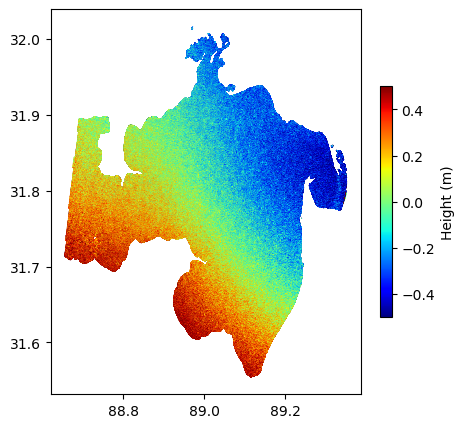

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
scat = ax.scatter(x=pixcs_spavar_xr.longitude, y=pixcs_spavar_xr.latitude, 
                  c=pixcs_spavar_xr['ht_ellip_spavar'].values,
                  s=0.5, edgecolor='none', cmap='jet',
                  vmin=-0.5, vmax=0.5)
plt.colorbar(scat, label='Height (m)', shrink=0.6)  


### 2. convert multitemporal pixc-based spatial variation of height to raster data

In [9]:
xmin, ymin, xmax, ymax = lake_gdf.geometry[0].buffer(0.01).bounds
raster_extent = (xmin, xmax, ymin, ymax)
print('raster extent:', raster_extent)
lat_center = pixcs_spavar_ls[0]['geoid'].latitude.mean().values
res_lon, res_lat = meter2deg(meter=500, lat=lat_center)
print('resolution (lon, lat):', res_lon, res_lat)


raster extent: (88.52279004460901, 89.36459400967644, 31.543057952710548, 32.028777144282756)
resolution (lon, lat): 0.005290123475443538 0.004496608029593653


In [10]:
raster_ht_ellip_spavar = pixc2raster(pixc_var = pixcs_spavar_xr['ht_ellip_spavar'], 
                        raster_extent=raster_extent,
                        pixc_lonlat=(pixcs_spavar_xr.longitude.values, pixcs_spavar_xr.latitude.values), 
                        resolution=(res_lon, res_lat), agg_method='median')
raster_ht_ellip_spavar.name = "height_spavar_smoothed"
raster_ht_ellip_spavar


<xarray.DataArray 'height_spavar_smoothed' (y: 109, x: 160)> Size: 140kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x        (x) float64 1kB 88.52 88.53 88.53 88.54 ... 89.35 89.35 89.36 89.36
  * y        (y) float64 872B 32.03 32.02 32.02 32.02 ... 31.55 31.55 31.54

In [11]:
## normalization
raster_ht_ellip_spavar.values =  raster_ht_ellip_spavar.values - np.nanmedian(raster_ht_ellip_spavar.values)

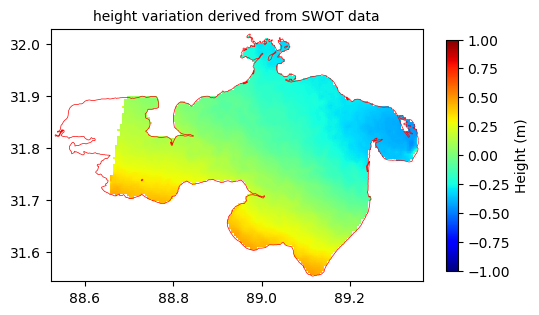

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
## ax1
scat1 = ax.imshow(raster_ht_ellip_spavar.values, cmap='jet', extent=raster_extent,
             vmin=-1, vmax=1
             )
lake_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=0.5)
ax.set_title('height variation derived from SWOT data', fontsize=10)
plt.colorbar(scat1, ax=ax, label='Height (m)', shrink=0.5)


In [13]:
raster_ht_ellip_spavar.attrs['description'] = 'the swot data-derived spatial variation of ellipsoidal height of the lake'
raster_height_spavar_ds = xr.Dataset({
    'ht_spavar_smoothed': raster_ht_ellip_spavar.rename('ht_spavar_smoothed')
    })
raster_height_spavar_ds
# # Save as NetCDF file
path_raster_height_spavar = dir_pixc + '/raster_height_spavar.nc'
raster_height_spavar_ds.to_netcdf(path_raster_height_spavar)
